## Analysis 1 (merge/split clouds)

In [84]:
import datetime as dt
import itertools
from pathlib import Path
from pprint import pprint

import cartopy.crs as ccrs
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import networkx as nx
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import xarray as xr

from mcs_prime import McsTracks, PATHS
from mcs_prime.util import update_progress
%matplotlib inline

Load all tracks from 2000/6-2020/12

In [2]:
tracks = tracks = McsTracks.load(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                                 PATHS['pixeldir'])
tracks

McsTracks[2019-01-01 00:30:00, 2019-12-31 22:30:00, ntracks=32843]

In [42]:
def generate_MCS_dag(tracks):
    tracks.dstracks.cloudnumber.load()
    tracks.dstracks.start_split_cloudnumber.load()
    tracks.dstracks.end_merge_cloudnumber.load()
    tracks.dstracks.base_time.load()

    G = nx.DiGraph()

    for trackid in tracks.dstracks.tracks.values:
        if trackid % 100 == 0:
            print(f'{trackid / len(tracks.dstracks.tracks) * 100:.1f}%')
        # print(trackid)
        track = tracks.get_track(trackid)

        found_prev_tracks = 0
        found_next_tracks = 0
        if track.dstrack.start_split_cloudnumber > 0:
            sscn = track.dstrack.start_split_cloudnumber.values.item()
            mask = ((tracks.dstracks.cloudnumber == sscn) & 
                    (tracks.dstracks.base_time == track.base_time[0] - int(3600e9))).any(axis=1)
            if mask.sum() == 1:
                ds_prev_track = tracks.dstracks.isel(tracks=mask).isel(tracks=0)
                index1 = np.where(ds_prev_track.base_time.values == track.base_time[0] - int(3600e9))[0][0]
                n1 = (ds_prev_track.tracks.values.item(), index1)
                n2 = (track.dstrack.tracks.values.item(), 0)
                G.add_edge(n1, n2, type='s')
        if track.dstrack.end_merge_cloudnumber > 0:
            emcn = track.dstrack.end_merge_cloudnumber.values.item()
            mask = ((tracks.dstracks.cloudnumber == emcn) & 
                    (tracks.dstracks.base_time == track.base_time[-1] + int(3600e9))).any(axis=1)
            if mask.sum() == 1:
                ds_next_track = tracks.dstracks.isel(tracks=mask).isel(tracks=0)
                index1 = track.duration - 1
                index2 = np.where(ds_next_track.base_time.values == track.base_time[-1] + int(3600e9))[0][0]
                n1 = (track.dstrack.tracks.values.item(), index1)
                n2 = (ds_next_track.tracks.values.item(), index2)
                G.add_edge(n1, n2, type='m')
                # prev_track = McsTrack(ds_prev_track.tracks.values.item(), ds_prev_track, tracks.pixel_data)
    return G

In [29]:
mcs_dag_path = Path('/home/users/mmuetz/data/mcs_prime/dev/tmp/MCS_DAG_2019.pkl')
if not mcs_dag_path.parent.exists():
    mcs_dag_path.parent.mkdir(exist_ok=True, parents=True)

In [59]:
if mcs_dag_path.exists():
    print('loading G')
    G = nx.read_gpickle(mcs_dag_path)
else:
    print('generating G')
    G = generate_MCS_dag(tracks)
    nx.write_gpickle(G, mcs_dag_path)

loading G


In [60]:
nx.is_directed_acyclic_graph(G)

True

In [61]:
nx.dag_longest_path(G)

[(2839, 4), (2832, 7), (2861, 0), (2865, 0)]

In [62]:
list(nx.bfs_successors(G, (2839, 4)))

[((2839, 4), [(2832, 7)]),
 ((2832, 7), [(2861, 0), (2862, 0)]),
 ((2861, 0), [(2865, 0)])]

In [63]:
subgraphs = [G.subgraph(c) for c in nx.connected_components(G.to_undirected())]

In [64]:
max(len(s) for s in subgraphs)

6

In [65]:
[s.edges for s in subgraphs if len(s) == 6]

[OutEdgeView([((17950, 4), (17981, 0)), ((17950, 4), (17982, 0)), ((17950, 4), (17983, 0)), ((17891, 20), (17950, 4)), ((17870, 25), (17950, 4))])]

In [114]:
longest_subgraph = [s for s in subgraphs if len(s) == 5][0]

In [115]:
trackids = [n[0] for n in longest_subgraph.nodes]

In [116]:
trackids

[2862, 2832, 2865, 2839, 2861]

In [117]:
ctracks = [tracks.get_track(t) for t in trackids]

(-8.512759685516357, 3.800791382789612)

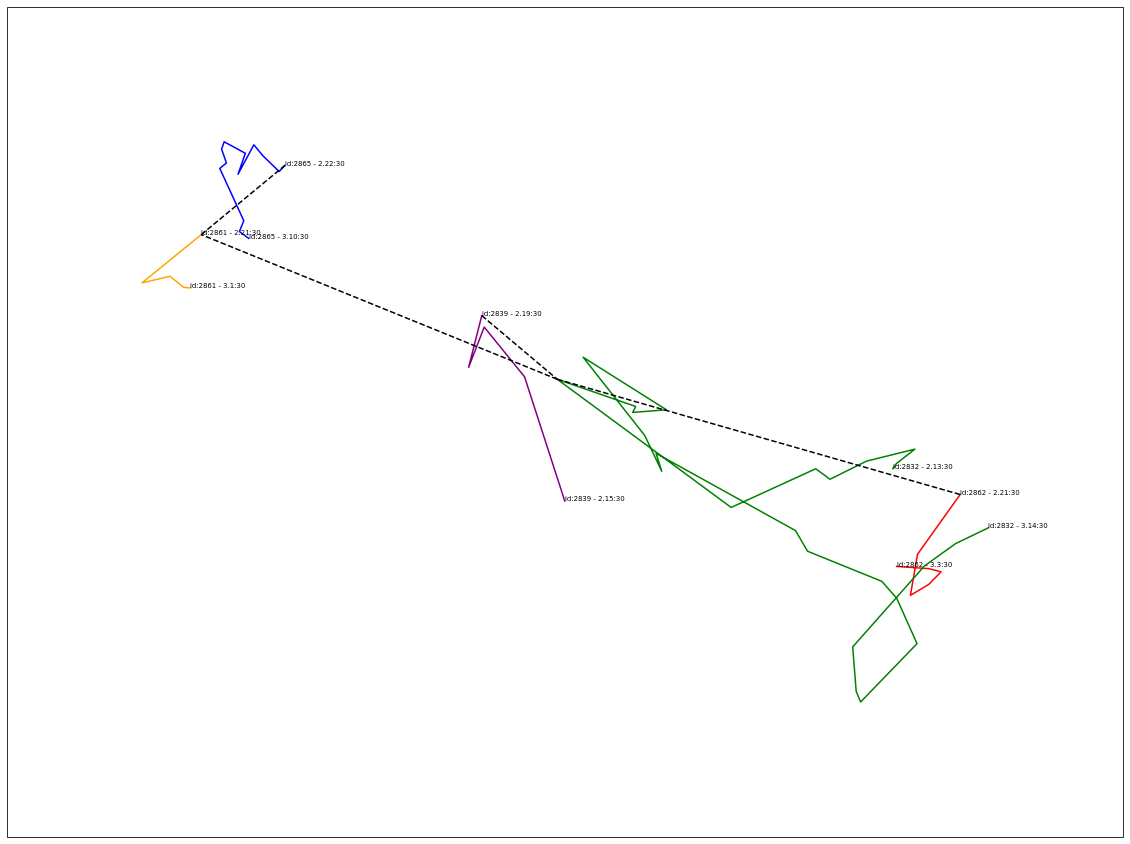

In [132]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((20, 20))


colours = ['r', 'g', 'b', 'purple', 'orange', 'black']
minlon, maxlon = 180, -180
minlat, maxlat = 60, -60
for c, t in zip(colours, ctracks):
    t.plot(ax=ax, display_area=False, display_pf_area=False, colour=c)
    minlon = min(minlon, t.meanlon.min())
    maxlon = max(maxlon, t.meanlon.max())
    minlat = min(minlat, t.meanlat.min())
    maxlat = max(maxlat, t.meanlat.max())


for e in longest_subgraph.edges:
    t1id, t1index = e[0]
    t2id, t2index = e[1]
    t1 = tracks.get_track(t1id)
    t2 = tracks.get_track(t2id)
    plt.plot([t1.meanlon[t1index], t2.meanlon[t2index]], [t1.meanlat[t1index], t2.meanlat[t2index]], 'k--')
    
    
ax.set_xlim((minlon - 2, maxlon + 2))
ax.set_ylim((minlat - 2, maxlat + 2))

In [75]:
pprint(list(zip(colours, ctracks)))

[('r',
  McsTrack[2019-07-17 13:30:00, 2019-07-18 11:30:00, id=17981, duration=23]),
 ('g',
  McsTrack[2019-07-17 08:30:00, 2019-07-17 18:30:00, id=17950, duration=11]),
 ('b',
  McsTrack[2019-07-16 15:30:00, 2019-07-17 11:30:00, id=17891, duration=21]),
 ('purple',
  McsTrack[2019-07-17 13:30:00, 2019-07-17 20:30:00, id=17982, duration=8]),
 ('orange',
  McsTrack[2019-07-16 10:30:00, 2019-07-17 11:30:00, id=17870, duration=26]),
 ('black',
  McsTrack[2019-07-17 13:30:00, 2019-07-18 01:30:00, id=17983, duration=13])]


In [71]:
pprint(list(longest_subgraph.edges))

[((17950, 4), (17981, 0)),
 ((17950, 4), (17982, 0)),
 ((17950, 4), (17983, 0)),
 ((17891, 20), (17950, 4)),
 ((17870, 25), (17950, 4))]


What is going on here? The track starts at 17.8:30 (green). At 17.11:30, orange and blue merge into green (at 17.12:30, which splits into black purple and red. This tallies with edges above as well.

In [121]:
subtracks = tracks.dstracks.sel(tracks=trackids)

In [122]:
start = np.nanmin(subtracks.base_time.values)
end = np.nanmax(subtracks.base_time.values)

In [123]:
end

numpy.datetime64('2019-02-03T14:30:00.000000000')

In [83]:
frame = tracks.pixel_data.get_frame(pd.Timestamp(time).to_pydatetime())

In [124]:
time = start
times = []
while time <= end:
    times.append(time)
    time += int(3600e9)

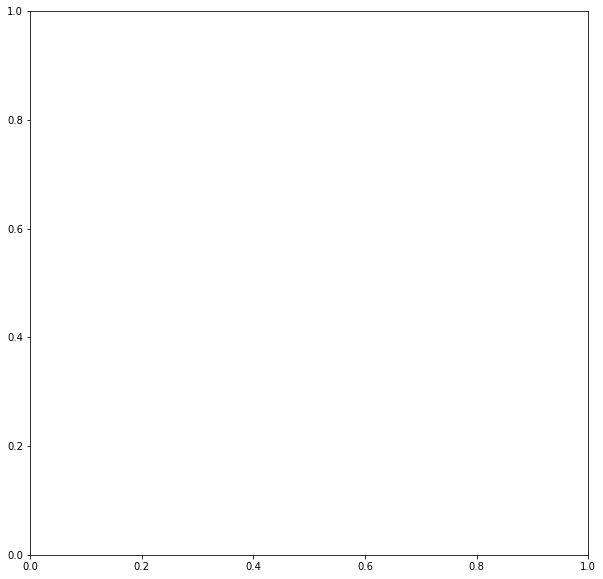

In [135]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))

In [136]:
def plot_anim_frame(time):
    pytime = pd.Timestamp(time).to_pydatetime()
    print(time)
    ax.clear()
    ax.set_title(time)
    for c, t in zip(colours, ctracks):
        if time >= t.base_time[0] and time <= t.base_time[-1]:
            t.plot(ax=ax, display_area=False, display_pf_area=False, colour=c)
            idx = np.where(t.base_time == time)[0][0]
            ax.plot(t.meanlon[idx], t.meanlat[idx], color=c, marker='o')
        else:
            t.plot(ax=ax, display_area=False, display_pf_area=False, colour=c)
    for e in longest_subgraph.edges:
        t1id, t1index = e[0]
        t2id, t2index = e[1]
        t1 = tracks.get_track(t1id)
        t2 = tracks.get_track(t2id)
        ax.plot([t1.meanlon[t1index], t2.meanlon[t2index]], [t1.meanlat[t1index], t2.meanlat[t2index]], 'k--')

    frame = tracks.pixel_data.get_frame(pytime)
    for c, track in zip(colours, ctracks):
        cnvals = track.cloudnumber[track.base_time == time]
        if len(cnvals):
            cn = cnvals[0]
            ax.contour(frame.dspixel.lon, frame.dspixel.lat, frame.dspixel.cloudnumber[0] == cn, levels=[0.5], colors=[c])
    ax.set_xlim((minlon - 5, maxlon + 5))
    ax.set_ylim((minlat - 5, maxlat + 5))

# plot_anim_frame(ctracks, tracks, start)
anim = matplotlib.animation.FuncAnimation(fig, plot_anim_frame, frames=times, interval=500)
anim

2019-02-02T13:30:00.000000000
2019-02-02T13:30:00.000000000
2019-02-02T14:30:00.000000000
2019-02-02T15:30:00.000000000
2019-02-02T16:30:00.000000000
2019-02-02T17:30:00.000000000
2019-02-02T18:30:00.000000000
2019-02-02T19:30:00.000000000
2019-02-02T20:30:00.000000000
2019-02-02T21:30:00.000000000
2019-02-02T22:30:00.000000000
2019-02-02T23:30:00.000000000
2019-02-03T00:30:00.000000000
2019-02-03T01:30:00.000000000
2019-02-03T02:30:00.000000000
2019-02-03T03:30:00.000000000
2019-02-03T04:30:00.000000000
2019-02-03T05:30:00.000000000
2019-02-03T06:30:00.000000000
2019-02-03T07:30:00.000000000
2019-02-03T08:30:00.000000000
2019-02-03T09:30:00.000000000
2019-02-03T10:30:00.000000000
2019-02-03T11:30:00.000000000
2019-02-03T12:30:00.000000000
2019-02-03T13:30:00.000000000
2019-02-03T14:30:00.000000000
